In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# autoreload   
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


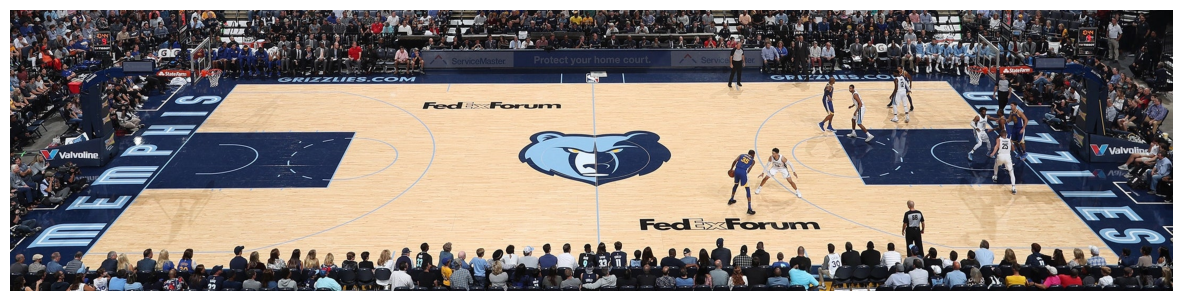

In [64]:
#Load the image
img = cv2.imread('./memphis.jpeg')
#Convert the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#plot the image
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Feature extraction
In this section three ellipses are extracted from the image

In [65]:
def plot_points(points, color='r', label=None):
    """
    Plot points on the image.
    """
    plt.scatter(points[:, 0], points[:, 1], c=color, marker='x', label=label, s=10, linewidths=.5)

### Point selection (manual)

In [66]:
if False:
    %matplotlib tk
    # Display the image and allow the user to select points interactively
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Select points of the first circle')

    def select_points(obj_name:str, color='r'):
        """
        Function to select points on the image.
        :param obj_name: Name of the object to select points for.
        :return: List of selected points.
        """
        plt.title(f'Select points for {obj_name}')
        print(f"Please select points for {obj_name} and press Enter when done.")
        points = plt.ginput(n=-1, timeout=0)  # n=-1 allows unlimited points, timeout=0 waits indefinitely
        print(f"Selected points for {obj_name}:", points)

        plot_points(np.array(points), color=color, label=obj_name)
        plt.legend()
        return points

    # Use ginput to select points
    points_C1 = select_points("Circle 1", color='r')
    points_C2 = select_points("Circle 2", color='g')
    points_C3 = select_points("Circle 3", color='b')

    plt.close()

    %matplotlib inline
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Selected Points')
    plot_points(np.array(points_C1), color='r', label='Circle 1')
    plot_points(np.array(points_C2), color='g', label='Circle 2')
    plot_points(np.array(points_C3), color='b', label='Circle 3')
    plt.legend()
    plt.show()

    #Save the points to a file
    with open('selected_points.txt', 'w') as f:
        f.write("Circle 1:\n")
        for point in points_C1:
            f.write(f"{point[0]}, {point[1]}\n")
        f.write("\nCircle 2:\n")
        for point in points_C2:
            f.write(f"{point[0]}, {point[1]}\n")
        f.write("\nCircle 3:\n")
        for point in points_C3:
            f.write(f"{point[0]}, {point[1]}\n")

Loaded points for Circle 1: [[531.51612903 273.90388441]
 [566.98387097 319.22377688]
 [643.83064516 321.19420699]
 [714.76612903 297.5490457 ]
 [728.55913978 269.96302419]
 [671.41666667 246.3178629 ]
 [594.56989247 248.28829301]]
Loaded points for Circle 2: [[1004.41935484  285.72646505]
 [1144.31989247  315.28291667]
 [1199.49193548  295.57861559]
 [1181.75806452  254.19958333]
 [1051.70967742  248.28829301]
 [1018.21236559  262.08130376]
 [1102.94086022  240.40657258]]
Loaded points for Circle 3: [[1538.40591398  242.37700269]
 [1506.87903226  246.3178629 ]
 [1479.29301075  267.99259409]
 [1526.58333333  305.43076613]
 [1595.5483871   317.25334677]
 [1676.33602151  297.5490457 ]
 [1642.83870968  250.25872312]]


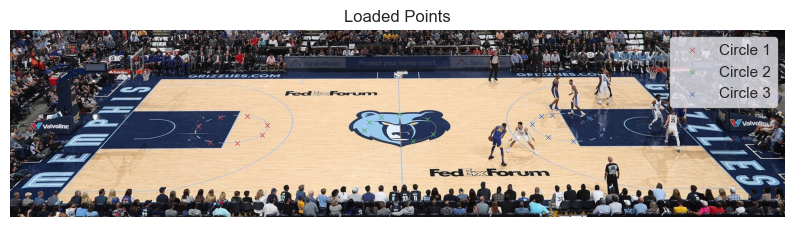

In [67]:
#Read points from the file
with open('selected_points.txt', 'r') as f:
    lines = f.readlines()
    points_C1 = []
    points_C2 = []
    points_C3 = []
    current_circle = None

    for line in lines:
        line = line.strip()
        if line.startswith("Circle 1:"):
            current_circle = points_C1
        elif line.startswith("Circle 2:"):
            current_circle = points_C2
        elif line.startswith("Circle 3:"):
            current_circle = points_C3
        elif line and current_circle is not None:
            x, y = map(float, line.split(','))
            current_circle.append((x, y))

    points_C1 = np.array(points_C1)
    points_C2 = np.array(points_C2)
    points_C3 = np.array(points_C3)

# Print the loaded points
print("Loaded points for Circle 1:", points_C1)
print("Loaded points for Circle 2:", points_C2)
print("Loaded points for Circle 3:", points_C3)

# centerX = img.shape[1] // 2
# centerY = img.shape[0] // 2
# center = np.array([centerX, centerY])

# scale = 1

# # Center the points around the center of the image
# points_C1 = points_C1 - center
# points_C1 = points_C1 * scale

# points_C2 = points_C2 - center
# points_C2 = points_C2 * scale

# points_C3 = points_C3 - center
# points_C3 = points_C3 * scale

%matplotlib inline
#Plot the loaded points
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Loaded Points')
plot_points(points_C1, color='r', label='Circle 1')
plot_points(points_C2, color='g', label='Circle 2')
plot_points(points_C3, color='b', label='Circle 3')
plt.legend()
plt.show()

### Fit Ellipse to points

In [68]:
from HomoTopiContinuation.DataStructures.datastructures import Conic, Conics, Homography

In [69]:
def getConic(x0, y0, MA, ma, theta):
    a = MA / 2
    b = ma / 2
    theta_rad = np.deg2rad(theta)
    c, s = np.cos(theta_rad), np.sin(theta_rad)

    A = (c**2) / (a**2) + (s**2) / (b**2)
    B = 2 * c * s * (1/(a**2) - 1/(b**2))
    C = (s**2) / (a**2) + (c**2) / (b**2)
    D = -2*A*x0 - B*y0
    E = -2*C*y0 - B*x0
    F = A*x0**2 + B*x0*y0 + C*y0**2 - 1
    matrix = np.array([[A, B/2, D/2], [B/2, C, E/2], [D/2, E/2, F]])
    matrix /= matrix[0, 0]  # Normalize the matrix
    return Conic(matrix)

In [70]:
# Fit ellipses to the points using OpenCV
ellipse_C1 = cv2.fitEllipse(points_C1.astype(np.float32))
ellipse_C2 = cv2.fitEllipse(points_C2.astype(np.float32))
ellipse_C3 = cv2.fitEllipse(points_C3.astype(np.float32))

print("Ellipse parameters for Circle 1:", ellipse_C1)
print("Ellipse parameters for Circle 2:", ellipse_C2)
print("Ellipse parameters for Circle 3:", ellipse_C3)

#Convert the ellipses to matrix form
C1 = getConic(*ellipse_C1[0], *ellipse_C1[1], ellipse_C1[2])
C2 = getConic(*ellipse_C2[0], *ellipse_C2[1], ellipse_C2[2])
C3 = getConic(*ellipse_C3[0], *ellipse_C3[1], ellipse_C3[2])

print("Conic matrix for Circle 1:\n", C1.M)
print("Conic matrix for Circle 2:\n", C2.M)
print("Conic matrix for Circle 3:\n", C3.M)

Ellipse parameters for Circle 1: ((626.0374145507812, 283.71142578125), (77.74598693847656, 207.19590759277344), 85.92876434326172)
Ellipse parameters for Circle 2: ((1106.1622314453125, 280.01593017578125), (77.73226165771484, 203.18209838867188), 89.32938385009766)
Ellipse parameters for Circle 3: ((1582.3193359375, 277.9340515136719), (75.87484741210938, 205.82199096679688), 94.05906677246094)
Conic matrix for Circle 1:
 [[ 1.00000000e+00  4.19262094e-01 -7.44986861e+02]
 [ 4.19262094e-01  6.86063198e+00 -2.20891344e+03]
 [-7.44986861e+02 -2.20891344e+03  1.08267137e+06]]
Conic matrix for Circle 2:
 [[ 1.00000000e+00  6.82034430e-02 -1.12526028e+03]
 [ 6.82034430e-02  6.82606849e+00 -1.98685199e+03]
 [-1.12526028e+03 -1.98685199e+03  1.79075813e+06]]
Conic matrix for Circle 3:
 [[ 1.00000000e+00 -4.35093028e-01 -1.46139217e+03]
 [-4.35093028e-01  7.10040459e+00 -1.28498810e+03]
 [-1.46139217e+03 -1.28498810e+03  2.65926735e+06]]


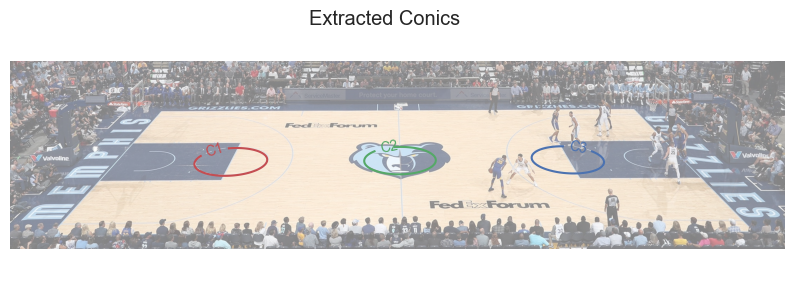

In [71]:
from HomoTopiContinuation.Plotter.Plotter import Plotter
plotter = Plotter(1, 1, title = "Extracted Conics", figsize=(10, 3))
plotter.newAxis(axisSame=False)
plotter.getCurrentAxis().imshow(img, alpha=0.5)
plotter.getCurrentAxis().axis('off')
plotter.getCurrentAxis().grid(False)
plotter.plotConic2D(C1, color='r', conicName="C1")
plotter.plotConic2D(C2, color='g', conicName="C2")
plotter.plotConic2D(C3, color='b', conicName="C3")
plotter.show()

# Rectification

Iteration 0, Loss: 0.19630885124206543
Iteration 1, Loss: 0.17784251272678375
Iteration 2, Loss: 0.1531165987253189
Iteration 3, Loss: 0.125022292137146
Iteration 4, Loss: 0.09659475088119507
Iteration 5, Loss: 0.0706203505396843
Iteration 6, Loss: 0.04935000091791153
Iteration 7, Loss: 0.03432970494031906
Iteration 8, Loss: 0.02630581520497799
Iteration 9, Loss: 0.025060702115297318
Iteration 10, Loss: 0.029218511655926704
Iteration 11, Loss: 0.03681446611881256
Iteration 12, Loss: 0.04611032083630562
Iteration 13, Loss: 0.05579664930701256
Iteration 14, Loss: 0.06492733210325241
Iteration 15, Loss: 0.072828009724617
Iteration 16, Loss: 0.07902206480503082
Iteration 17, Loss: 0.08317824453115463
Iteration 18, Loss: 0.08507636934518814
Iteration 19, Loss: 0.08458894491195679
Iteration 20, Loss: 0.08167615532875061
Iteration 21, Loss: 0.07639527320861816
Iteration 22, Loss: 0.06892551481723785
Iteration 23, Loss: 0.05961180105805397
Iteration 24, Loss: 0.04903291165828705
Iteration 25, 

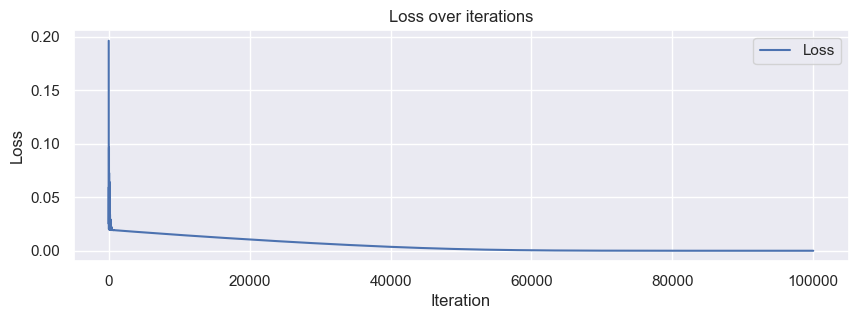

In [200]:
from HomoTopiContinuation.Rectifier.homotopyc_rectifier import HomotopyContinuationRectifier
from HomoTopiContinuation.Rectifier.numeric_rectifier import NumericRectifier
from HomoTopiContinuation.Rectifier.GDRectifier import GDRectifier
import jax.numpy as jnp

rectifier = GDRectifier
C1.M = C1.M / C1.M[2, 2]  # Normalize the conic matrix
C2.M = C2.M / C2.M[2, 2]  # Normalize the conic matrix
C3.M = C3.M / C3.M[2, 2]  # Normalize the conic matrix
H, history, losses, grads, vs = rectifier.rectify(Conics(C1, C2, C3), alpha=5e-4, iterations=100000, beta=.99, weights=jnp.array([1.0, 1.0, 1.0]), gradientCap=5.0)
print(H.H)

# Plot the losses
plt.figure(figsize=(10, 3))
plt.plot(losses, label='Loss')
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

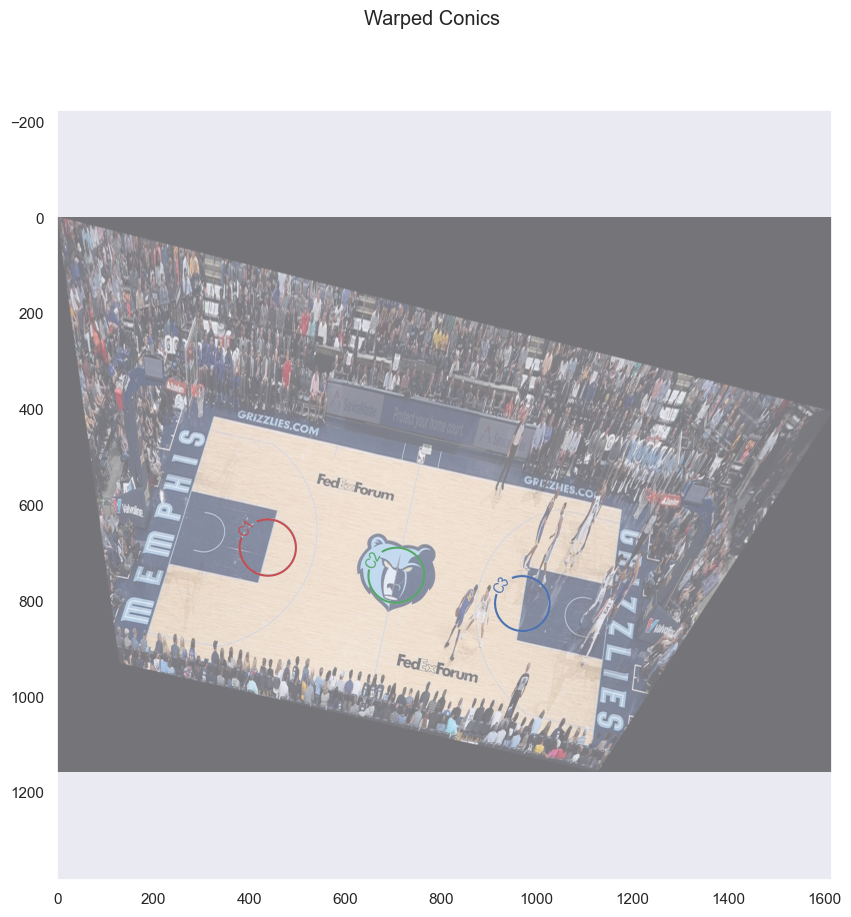

In [201]:
from HomoTopiContinuation.ImageWarper.ImageWarper import ImageWarper
warper = ImageWarper()
warped_img, adjH = ImageWarper()(img, H)
centerX_warped = warped_img.shape[1] // 2
centerY_warped = warped_img.shape[0] // 2
adjH = Homography(adjH)
# Rectify the conics using the homography
C1_warped = C1.applyHomography(adjH)
C2_warped = C2.applyHomography(adjH)
C3_warped = C3.applyHomography(adjH)

plotter = Plotter(1, 1, title = "Warped Conics", figsize=(10, 10))

plotter.newAxis(axisSame=True)
ax = plotter.getCurrentAxis()
ax.grid(False)
ax.imshow(warped_img, alpha=0.5)
plotter.plotConic2D(C1_warped, color='r', conicName="C1")
plotter.plotConic2D(C2_warped, color='g', conicName="C2")
plotter.plotConic2D(C3_warped, color='b', conicName="C3")

plotter.show()


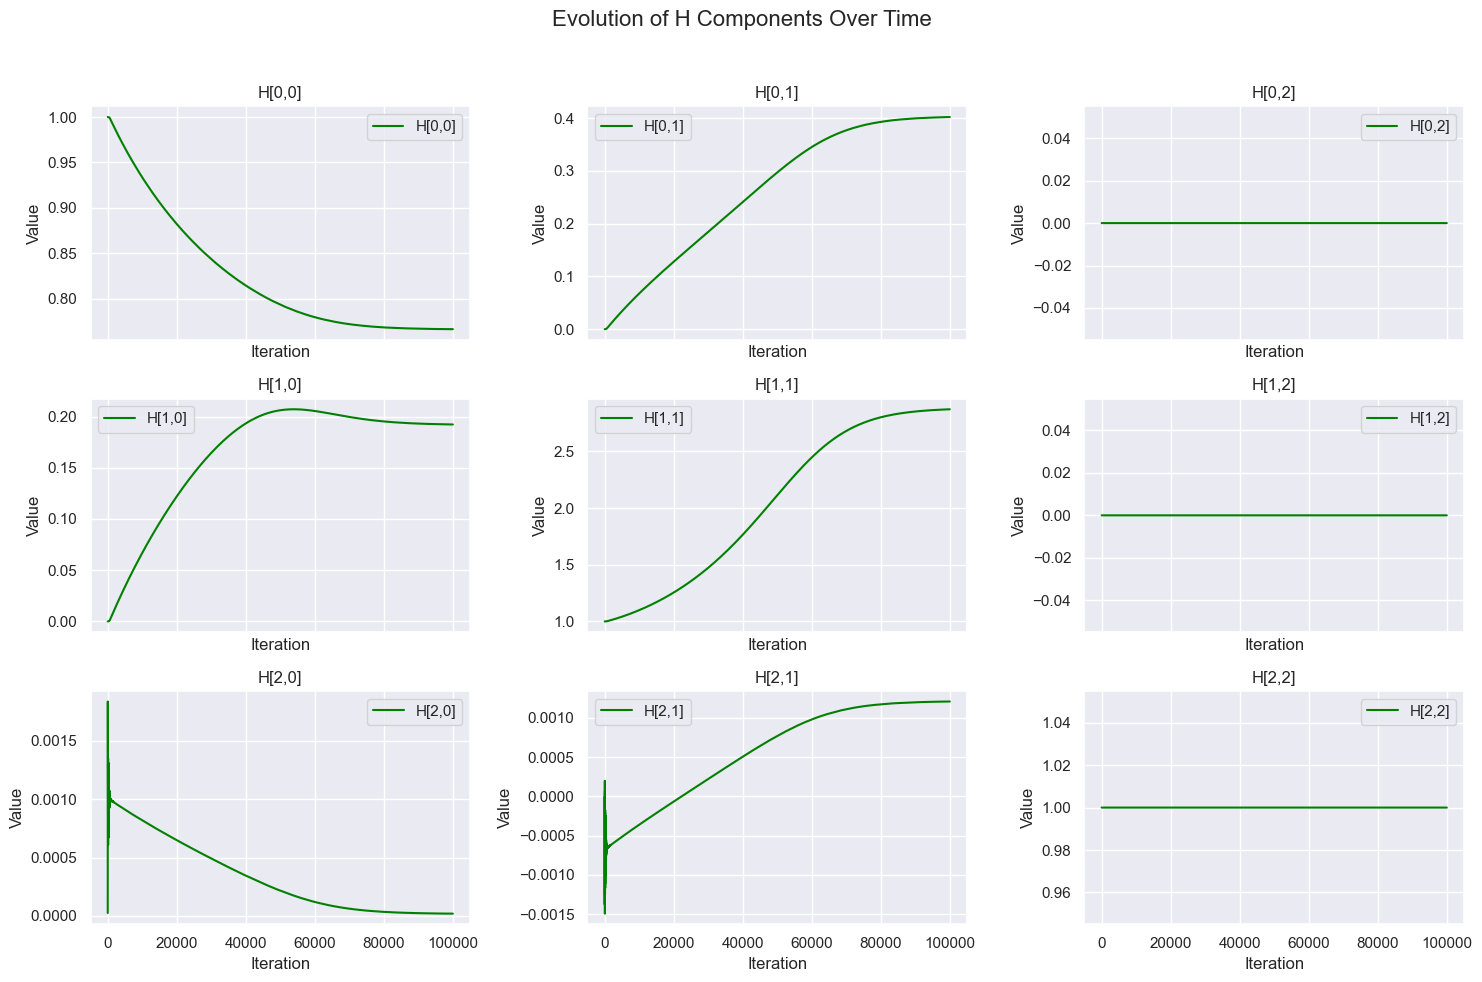

In [202]:
# Plot the evolution of each component of the 3x3 H matrix over time in a 3x3 grid

# Convert the list of Homography objects in history to a numpy array of shape (steps, 3, 3)
H_arr = np.array([h.H for h in history])  # shape: (steps, 3, 3)

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
fig.suptitle("Evolution of H Components Over Time", fontsize=16)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(H_arr[:, i, j], label=f'H[{i},{j}]', color='green')
        ax.set_title(f"H[{i},{j}]")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

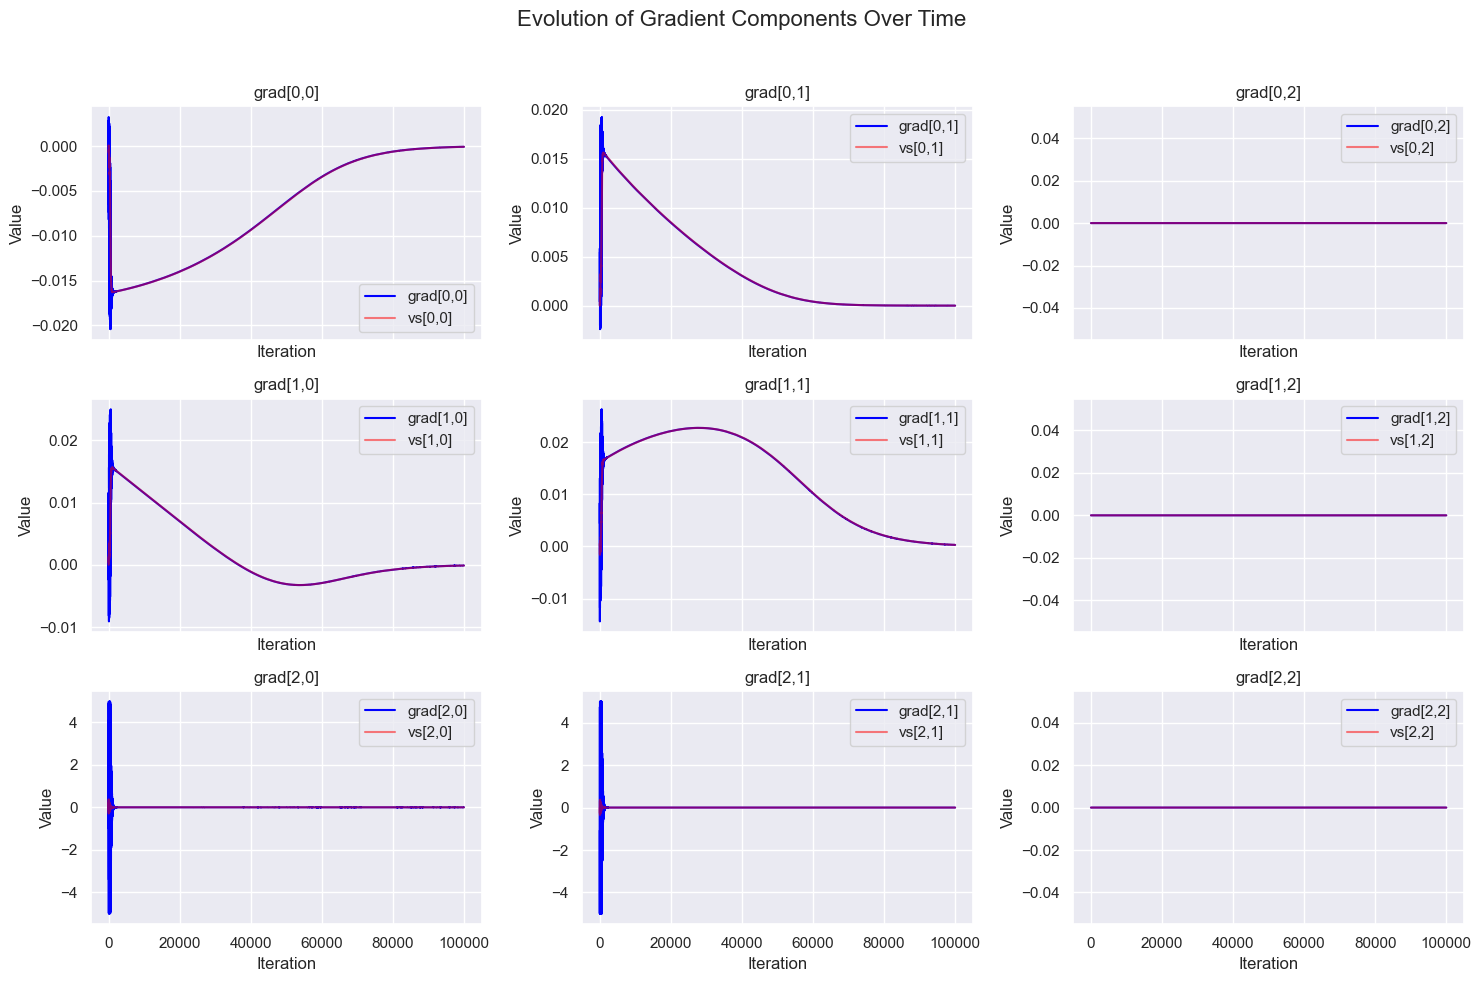

In [203]:
# Plot the evolution of each component of the 3x3 gradient matrix over time in a 3x3 grid

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
fig.suptitle("Evolution of Gradient Components Over Time", fontsize=16)

# grads is assumed to be a list of 3x3 matrices (e.g., jax.numpy arrays or numpy arrays)
grads_arr = np.array(grads)  # shape: (steps, 3, 3)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(grads_arr[:, i, j], label=f'grad[{i},{j}]', color='blue')
        ax.plot(vs[:, i, j], label=f'vs[{i},{j}]', color='red', alpha=0.5)
        ax.legend()
        ax.set_title(f"grad[{i},{j}]")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [204]:
from HomoTopiContinuation.Losser.CircleLosser import CircleLosser

CircleLosser.computeCircleLoss(None, Conics(C1_warped, C2_warped, C3_warped))

[np.float64(0.1319103884803863),
 np.float64(0.1964218585901047),
 np.float64(0.14616138069817808)]

In [206]:
from tqdm import tqdm

import cv2

SAVEVIDEO = True  # Set to True to save the video, False to skip
if SAVEVIDEO:
    video_frames = []
    video_size = None
    startupPeriod = 100
    period = 1000  # Plot every 100 steps
    firstPeriod = False

    for idx, H_step in enumerate(tqdm(history, desc="Generating frames")):
        if firstPeriod and (idx % period != 0 and idx != len(history) - 1):
            continue  # Skip frames except every 'period' and the last one

        firstPeriod = idx >= startupPeriod

        warped_img_step, adjH_step = warper(img, H_step)
        adjH_step = Homography(adjH_step)
        C1_warped_step = C1.applyHomography(adjH_step)
        C2_warped_step = C2.applyHomography(adjH_step)
        C3_warped_step = C3.applyHomography(adjH_step)

        plotter = Plotter(1, 1, title = f"Warped Conics step #{idx}", figsize=(10, 10))

        plotter.newAxis(axisSame=True)
        ax = plotter.getCurrentAxis()
        ax.grid(False)
        ax.imshow(warped_img_step, alpha=0.5)
        plotter.plotConic2D(C1_warped_step, color='r', conicName="C1")
        plotter.plotConic2D(C2_warped_step, color='g', conicName="C2")
        plotter.plotConic2D(C3_warped_step, color='b', conicName="C3")

        fig = plotter.figure
        fig.canvas.draw()

        # Convert plot to image
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frame = frame[..., :3]  # Drop alpha channel to get RGB
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)

        if video_size is None:
            video_size = (frame.shape[1], frame.shape[0])
        video_frames.append(frame)

    # Save video
    out = cv2.VideoWriter('rectification_history.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, video_size)
    for frame in video_frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    out.release()
    print(f"Video saved as rectification_history.mp4")

Generating frames: 100%|██████████| 100000/100000 [00:19<00:00, 5002.74it/s]


Video saved as rectification_history.mp4
